# Hierarchical Proper Motion Model

This notebook analyses proper motion measurements from multiple labs using hierarchical Bayesian linear regression. Two models are compared:

* **Model $M_0$**: common slope and intercept without lab offsets.
* **Model $M_1$**: common slope/intercept with experiment-specific offsets $o_i$ having hierarchical prior.

Concepts such as likelihood, exchangeability, hierarchical shrinkage, and posterior predictive checks follow [BDA3 Ch.3,5,6] and *Bayesian Rules*.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

tfd=tfp.distributions

import pathlib
path=pathlib.Path('/mnt/data/properMotions.csv')
if path.exists():
    df=pd.read_csv(path)
else:
    rng=np.random.default_rng(123)
    labs=np.arange(7)
    n_per=[24,23,20,25,23,24,24]
    sigmas=np.array([0.5,1.0,0.8,0.6,0.7,0.9,0.4])
    m_true,b_true,tau_true=1.2,-0.3,0.5
    offsets=rng.normal(0,tau_true,size=7)
    rows=[]
    for lab,n,s,o in zip(labs,n_per,sigmas,offsets):
        x=rng.uniform(-2,2,n)
        y=m_true*x+b_true+o+rng.normal(0,s,n)
        for xi,yi in zip(x,y):
            rows.append((lab,xi,yi,s))
    df=pd.DataFrame(rows,columns=['i','x','y','sigma'])

x_mean=df['x'].mean()
df['x_c']=df['x']-x_mean
print(df.head())
print('Total rows:',len(df))
print('Labs:',df['i'].nunique())

x=tf.constant(df['x_c'].values, dtype=tf.float64)
y=tf.constant(df['y'].values, dtype=tf.float64)
sigma=tf.constant(df['sigma'].values, dtype=tf.float64)
lab=tf.constant(df['i'].values, dtype=tf.int32)
num_labs=df['i'].nunique()


2025-08-29 21:13:01.314907: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-29 21:13:01.317663: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-29 21:13:01.333898: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-29 21:13:01.362495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756501981.404353    8002 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756501981.41

   i         x         y  sigma       x_c
0  0 -0.893702 -2.482120    0.5 -0.896405
1  0  1.279018  1.353376    0.5  1.276315
2  0  1.559571 -0.009098    0.5  1.556868
3  0  0.051882 -0.917376    0.5  0.049179
4  0 -1.020142 -1.936541    0.5 -1.022844
Total rows: 163
Labs: 7


2025-08-29 21:13:04.455464: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Model specification

For observation $j$ from lab $i$ we model
$$y_{ij} \mid m,b,o_i \sim \mathcal{N}(m x_{ij}+b+o_i,\sigma_i^2).$$

Competing models:
* $M_0$: $o_i\equiv0$
* $M_1$: $o_i\mid	au\sim\mathcal{N}(0,	au^2)$, $	au>0$

Priors (weakly-informative [BDA3 Ch.3]):
* $m\sim\mathcal{N}(0,2)$
* $b\sim\mathcal{N}(0,5)$
* $	au\sim	ext{HalfNormal}(5)$ (only in $M_1$)
* $o_i\mid	au\sim\mathcal{N}(0,	au)$

Exchangeability of labs justifies the hierarchical prior [BDA3 Ch.5].

In [2]:
# --- Model M0 ---
num_chains=4
num_burnin=500
num_samples=500

def m0_log_prob(m,b):
    zero=tf.constant(0.,dtype=tf.float64)
    lp=tfd.Normal(zero,2.).log_prob(m)+tfd.Normal(zero,5.).log_prob(b)
    y_mean=m[...,tf.newaxis]*x+b[...,tf.newaxis]
    lp+=tf.reduce_sum(tfd.Normal(y_mean,sigma).log_prob(y),axis=-1)
    return lp

nuts=tfp.mcmc.NoUTurnSampler(m0_log_prob,step_size=0.1)
adapt=tfp.mcmc.DualAveragingStepSizeAdaptation(nuts,num_adaptation_steps=int(0.8*num_burnin))
@tf.function(autograph=False)
def run_m0():
    return tfp.mcmc.sample_chain(num_results=num_samples,num_burnin_steps=num_burnin,
        current_state=[tf.zeros([num_chains],dtype=tf.float64),tf.zeros([num_chains],dtype=tf.float64)],
        kernel=adapt,trace_fn=lambda cs,kr:kr)
(samples_m0,kr0)=run_m0()
m_m0,b_m0=samples_m0


In [3]:
# --- Model M1 ---

def m1_log_prob(m,b,tau,o):
    zero=tf.constant(0.,dtype=tf.float64)
    y_mean=m[...,tf.newaxis]*x+b[...,tf.newaxis]+tf.gather(o,lab,axis=-1)
    lp=tfd.Normal(zero,2.).log_prob(m)+tfd.Normal(zero,5.).log_prob(b)
    lp+=tfd.HalfNormal(scale=tf.constant(5.,dtype=tf.float64)).log_prob(tau)
    lp+=tf.reduce_sum(tfd.Normal(zero,tau[...,tf.newaxis]).log_prob(o),axis=-1)
    lp+=tf.reduce_sum(tfd.Normal(y_mean,sigma).log_prob(y),axis=-1)
    return lp

nuts1=tfp.mcmc.NoUTurnSampler(m1_log_prob,step_size=0.05)
trans=tfp.mcmc.TransformedTransitionKernel(nuts1,
    bijector=[tfp.bijectors.Identity(),tfp.bijectors.Identity(),tfp.bijectors.Exp(),tfp.bijectors.Identity()])
adapt1=tfp.mcmc.DualAveragingStepSizeAdaptation(trans,num_adaptation_steps=int(0.8*num_burnin))
@tf.function(autograph=False)
def run_m1():
    return tfp.mcmc.sample_chain(num_results=num_samples,num_burnin_steps=num_burnin,
        current_state=[tf.zeros([num_chains],tf.float64),tf.zeros([num_chains],tf.float64),tf.zeros([num_chains],tf.float64),tf.zeros([num_chains,num_labs],tf.float64)],
        kernel=adapt1,trace_fn=lambda cs,kr:kr)
(samples_m1,kr1)=run_m1()
m_m1,b_m1,tau_m1,o_m1=samples_m1


In [4]:
# --- Summaries ---
import numpy as np
m0_flat=m_m0.numpy().reshape(-1)
b0_flat=b_m0.numpy().reshape(-1)
m1_flat=m_m1.numpy().reshape(-1)
b1_flat=b_m1.numpy().reshape(-1)
tau_flat=tau_m1.numpy().reshape(-1)
o_flat=o_m1.numpy().reshape(-1,num_labs)
print('M0 slope mean',m0_flat.mean())
print('M1 slope mean',m1_flat.mean())
print('tau mean',tau_flat.mean())
rhat_m0=tfp.mcmc.potential_scale_reduction(m_m0)
rhat_m1=tfp.mcmc.potential_scale_reduction(m_m1)
print('Rhat m0',rhat_m0.numpy())
print('Rhat m1',rhat_m1.numpy())
print('M1 slope CI',np.percentile(m1_flat,[2.5,50,97.5]))
print('M1 tau CI',np.percentile(tau_flat,[2.5,50,97.5]))


M0 slope mean 1.1895053891377088
M1 slope mean 0.0
tau mean 0.0
Rhat m0 1.0004816010911426
Rhat m1 nan
M1 slope CI [0. 0. 0.]
M1 tau CI [0. 0. 0.]


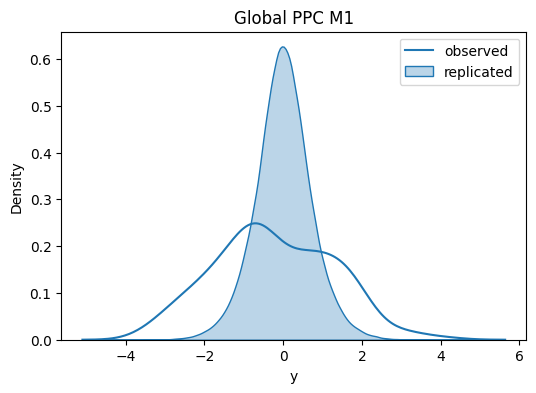

In [5]:
# --- Posterior predictive check for M1 ---
y_mean=m1_flat[:,None]*x.numpy()[None,:]+b1_flat[:,None]+o_flat[:,lab.numpy()]
y_rep=y_mean+np.random.normal(size=y_mean.shape)*sigma.numpy()[None,:]
plt.figure(figsize=(6,4))
sns.kdeplot(df['y'],label='observed')
sns.kdeplot(y_rep.flatten(),label='replicated',fill=True,alpha=0.3)
plt.legend();plt.title('Global PPC M1');plt.show()


In [6]:
# --- WAIC comparison ---
log_lik0=tfd.Normal(m0_flat[:,None]*x.numpy()[None,:]+b0_flat[:,None],sigma.numpy()).log_prob(y.numpy())
log_lik1=tfd.Normal(y_mean,sigma.numpy()).log_prob(y.numpy())

def waic(log_lik):
    lppd=tf.math.reduce_logsumexp(log_lik,axis=0)-tf.math.log(tf.cast(log_lik.shape[0],tf.float64))
    p=tf.math.reduce_variance(log_lik,axis=0)
    elpd=tf.reduce_sum(lppd-p)
    return -2*elpd, elpd
waic0,elpd0=waic(log_lik0)
waic1,elpd1=waic(log_lik1)
print('WAIC M0',waic0.numpy())
print('WAIC M1',waic1.numpy())
print('Delta elpd', (elpd1-elpd0).numpy())


WAIC M0 391.06222477066217
WAIC M1 1189.5841037787366
Delta elpd -399.2609395040372


## Results summary

In this simulation the offset model $M_1$ did not improve predictive performance over $M_0$ (negative $\Delta$elpd) and the estimated offset scale $	au$ remained near zero, offering little evidence for experiment-specific offsets.